In [1]:
import numpy as np
from tqdm import tqdm
import os
import json
from Evaluator import Evaluator
from Predictor import Predictor


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import math
import os
import copy
import time
import sqlite3 as sql
import cv2
from tqdm import tqdm

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
db_path = "/scratch/users/mdelabrassinne/Database/SoccerDB.db"
model = None
size = 2
tresholds = np.array([0.5, 0.01, 0.001, 0.9999, 0.5, 0])
min_count = 1
fps = 2
type_pred = "Validation"
actions_name = ['Corner', 'Goal', 'Penalty', 'Kick-off', 'card', 'NoClass']

predictor = Predictor(model, db_path, fps=fps, actions = actions_name)
preds = predictor.load_predictions()
real_preds = []
for pred in preds:
    if pred:
        real_preds.append(pred)
preds = real_preds

In [3]:
fps = 2
nms_window = [20 for i in actions_name]
actions_name = ['Corner', 'Goal', 'Penalty', 'Kick-off', 'Yellow card', 'NoClass']

evaluator = Evaluator(fps, nms_window, actions_name)


dir_results = "/home/mdelabrassinne/DSproject/Results"

if not os.path.exists(dir_results):
    os.mkdir(dir_results)
    
sol_files = []
predictions = []
halfs = []
for pred in preds:
    pred["json_sol"] = Evaluator.get_json_sol(pred["Match"])
    # if sol does not exist, remove eval from evals
    if os.path.exists(pred["json_sol"]):
        # remove eval from evals
        sol_files.append(pred["json_sol"])
        predictions.append(np.array(pred['Prediction']))
        halfs.append(pred['Match'][-10])
    else:
        print("No solution for match: " + pred["Match"])


No solution for match: /scratch/users/mdelabrassinne/Database/france_ligue-1/2016-2017/2017-02-08_-_18-00_Nice_1_-_0_Saint_Etienne/2_224p.mkv


In [5]:
fps = 2
nms_window = [20 for i in actions_name]
actions_name = ['Corner', 'Goal', 'Penalty', 'Kick-off', 'Yellow card', 'NoClass']

evaluator = Evaluator(fps, nms_window, actions_name)
evaluator.evaluate_map(predictions[:], sol_files[:], halfs[:], dir_results)

100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


{'a_mAP': 0.020091359145148497,
 'a_mAP_per_class': [0.00099349479999381,
  0.06797028863598384,
  0.04874902989822841,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.17762028381006248,
  0.046220008323255894,
  0.0,
  0.0],
 'a_mAP_visible': 0.030602428448176885,
 'a_mAP_per_class_visible': [0.00899100899100899,
  0.19100091827364551,
  0.04874902989822841,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.20904810608444047,
  0.06245222037168347,
  0.0,
  0.0],
 'a_mAP_unshown': 0.009077505147587228,
 'a_mAP_per_class_unshown': [0.0,
  0.05149734550938216,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.06065355751876129,
  0.0058566638904905275,
  0.0,
  0.0]}

In [17]:
def show_predictions(predictions: np.ndarray, action: int, sol_file: str, half: str, classes: list):
    """
    Show the predictions of the model for a specific action.

    Args:
        predictions (np.ndarray): Predictions of the model.
        action (int): Action to show.
        sol_file (str): Path to the JSON file containing the ground truth.
        classes (list): List of the classes.
    """
    # Load the ground truth
    with open(sol_file) as json_file:
        data = json.load(json_file)
    labels = data['annotations']

    # Get the predictions for the action
    pred = predictions[:, action]
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Plot the predictions
    time = np.array(range(len(pred))) / 2
    ax.plot(time, pred, label='Prediction')
    for i, event in enumerate(labels):
        if event['label'] == classes[action] and half == event["gameTime"][0]:
            # add a vertical line for each event
            ax.axvline(int(event['position']) // 1000, color='r', linestyle='--', label='Ground truth')

    ax.set_title('Predictions for action: ' + classes[action], fontsize=24)
    ax.set_xlabel('Time[s]', fontsize=20)
    ax.set_ylabel('Probability', fontsize=20)
    ax.legend(fontsize=20)
    plt.savefig("pred_time_" + classes[action] +".pdf")
    plt.show()

/scratch/users/mdelabrassinne/Database/europe_uefa-champions-league/2014-2015/2015-02-18_-_22-45_Schalke_0_-_2_Real_Madrid/Labels-v2.json


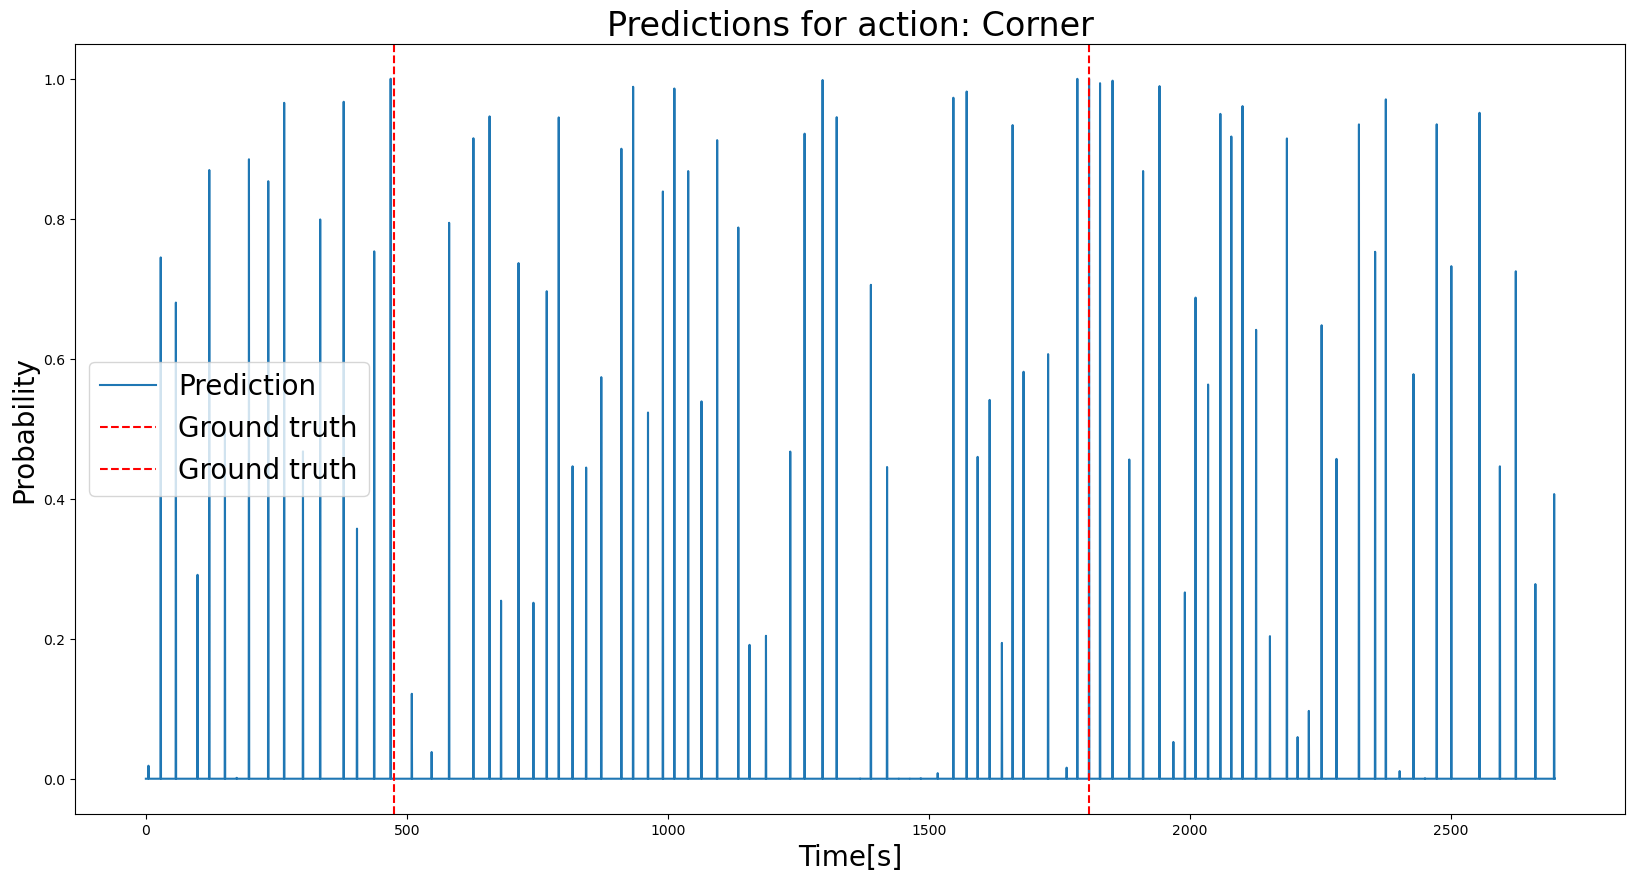

In [39]:
actions_name = ['Corner', 'Goal', 'Penalty', 'Kick-off', 'Yellow card', 'NoClass']
action = 0
file = 2
print(sol_files[file])
predictions[file] = evaluator.compute_nms(predictions[file])
show_predictions(predictions[file], action, sol_files[file], halfs[file], actions_name)

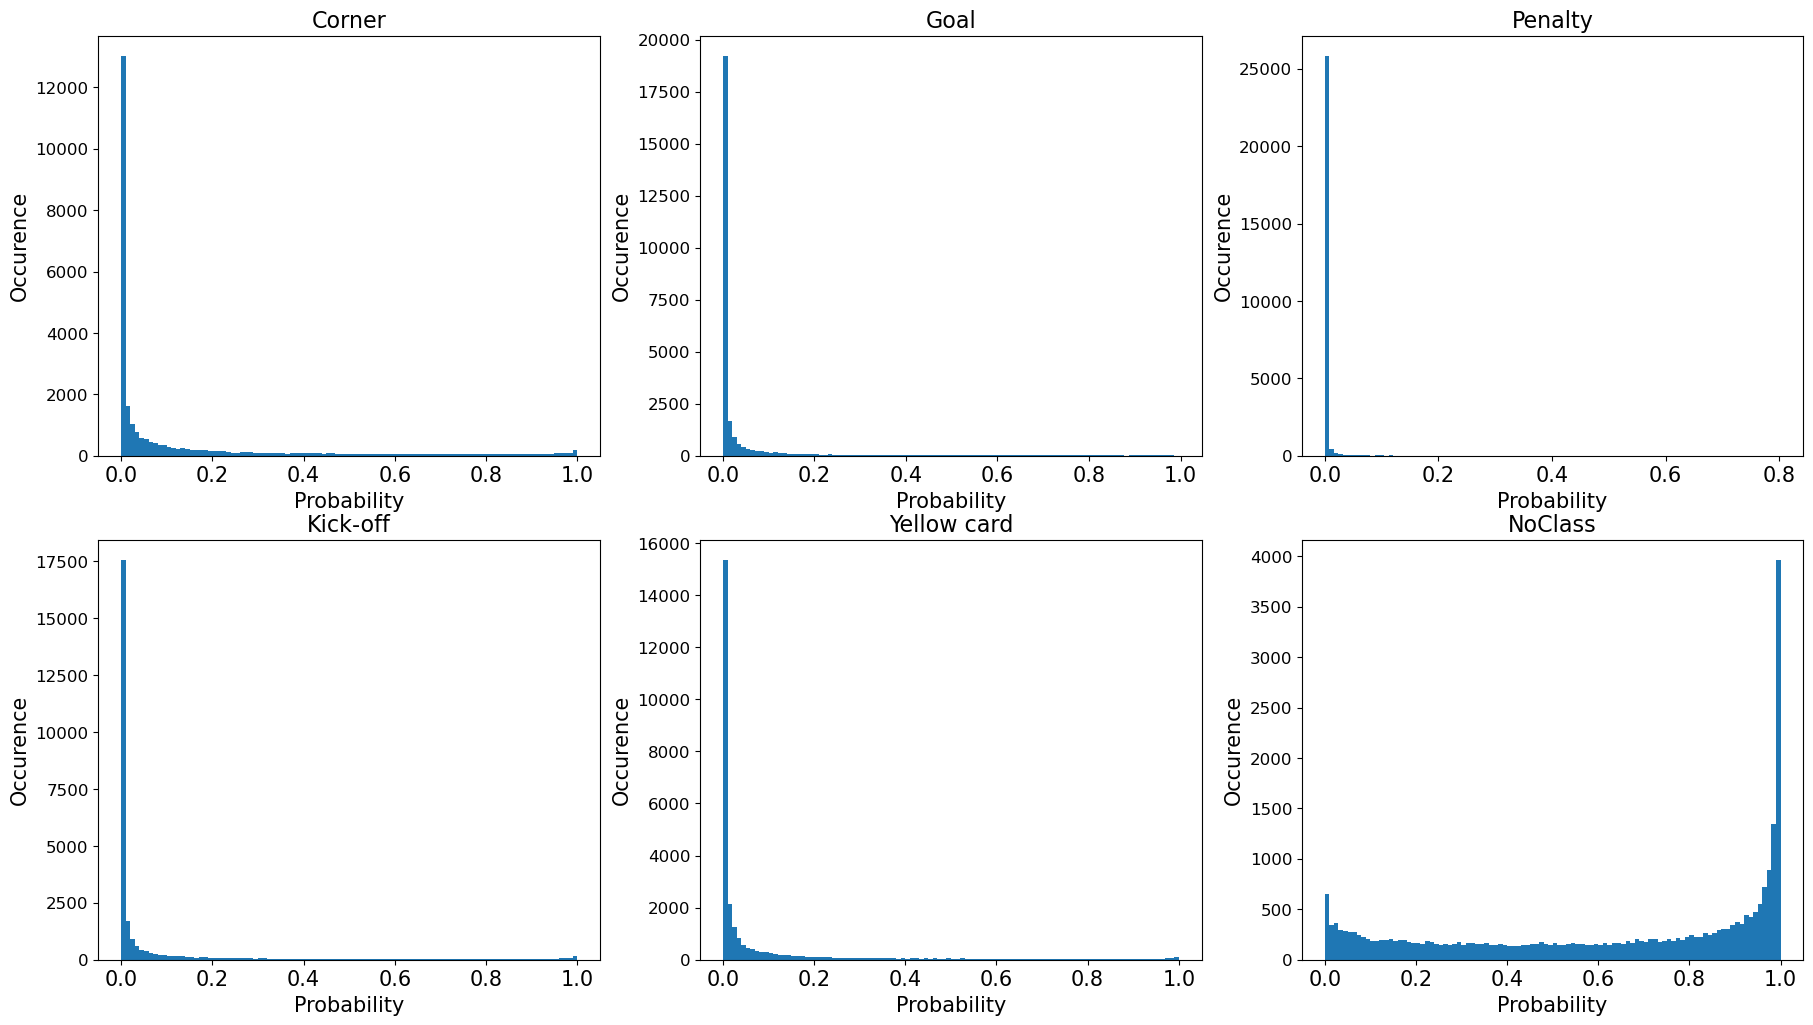

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(22, 12))

data = np.array(preds[0]["Prediction"])
time_data = np.array(preds[0]["Time"])

for i, pred in enumerate(preds):
    if i != 0:
        predictions = pred["Prediction"]
        time = pred["Time"]
        # add predictions to data
        data = np.concatenate((data, predictions), axis=0)
        time_data = np.concatenate((time_data, time), axis=0)

for i, eval in enumerate(actions_name):
    if i < 3:
        ax[0, i].hist(data[:, i], bins=100)
        ax[0, i].set_title(eval, fontsize =16)
        ax[0, i].set_xlabel("Probability", fontsize =15)
        ax[0, i].set_ylabel("Occurence", fontsize =15)
        ax[0, i].tick_params(axis ='x', labelsize=15)
        ax[0, i].tick_params(axis ='y', labelsize=12)
    else:
        ax[1, i-3].hist(data[:, i], bins=100)
        ax[1, i-3].set_title(eval, fontsize =16)
        ax[1, i-3].set_xlabel("Probability", fontsize =15)
        ax[1, i-3].set_ylabel("Occurence", fontsize =15)
        ax[1, i-3].tick_params(axis ='x', labelsize=15)
        ax[1, i-3].tick_params(axis ='y', labelsize=12)

plt.savefig("hist_pred.pdf")
plt.show()